<a href="https://colab.research.google.com/github/Farmhouse121/Adventures-in-Financial-Data-Science/blob/main/Book/Section%202.4%20Interest%20Rates/Section%202.4.2.3%20A%20Daily%20Vasicek%20GARCH(1%2C1)%20Model%20with%20Quiet%20Days%20Censored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Installing arch...")
!pip install arch 1>/dev/null
import pandas as pd
import numpy as np ;
import matplotlib.pyplot as pl
from datetime import datetime
zero,one,two,three,five,ten,hundred=0e0,1e0,2e0,3e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

Installing arch...


In [4]:
# get the bill rate data from Fred
DTB3=pd.read_table('https://fred.stlouisfed.org/data/DTB3.txt',skiprows=11,sep=r'\s+',header=0).rename(columns={"VALUE":"Rate","DATE":"Date"}).set_index("Date")
DTB3.index=pd.DatetimeIndex(DTB3.index).to_period('D')
DTB3['Rate']=DTB3['Rate'].apply(lambda x:float(x) if x!='.' else np.nan)

# join the recessions data (NBER data at Fred) 
USREC=pd.read_table('https://fred.stlouisfed.org/data/USREC.txt',skiprows=65,sep=r'\s+',header=0).rename(columns={"VALUE":"Recession","DATE":"Date"}).set_index("Date")
USREC.index=pd.DatetimeIndex(USREC.index).to_period('D')
DTB3=DTB3.merge(USREC,left_index=True,right_index=True,how='outer')
DTB3['Recession'].ffill(inplace=True)
DTB3['Recession']=DTB3['Recession'].apply(lambda x:True if x else False)
DTB3.dropna(inplace=True)
DTB3['Year']=DTB3.index.year
DTB3.index=pd.DatetimeIndex(DTB3.index.to_timestamp()).to_period('B') # business days
DTB3['Change']=DTB3['Rate']-DTB3['Rate'].shift().ffill() # changes that skip over holidays, why is this so hard?
DTB3.dropna(inplace=True)
display(DTB3)

,Rate,Recession,Year,Change
Date,,,,
1954-01-05,1.28,True,1954,-0.05
1954-01-06,1.28,True,1954,0.00
1954-01-07,1.31,True,1954,0.03
1954-01-08,1.31,True,1954,0.00
1954-01-11,1.33,True,1954,0.02
...,...,...,...,...
2023-03-28,4.64,False,2023,-0.11
2023-03-29,4.64,False,2023,0.00
2023-03-30,4.80,False,2023,0.16


,Rate,Recession,Year,Change
Date,,,,
1954-01-05,1.28,True,1954,-0.05
1954-01-07,1.31,True,1954,0.03
1954-01-11,1.33,True,1954,0.02
1954-01-12,1.30,True,1954,-0.03
1954-01-14,1.28,True,1954,-0.02
...,...,...,...,...
2023-03-27,4.75,False,2023,0.18
2023-03-28,4.64,False,2023,-0.11
2023-03-30,4.80,False,2023,0.16


Optimization terminated successfully    (Exit mode 0)
            Current function value: 43290.08334793482
            Iterations: 19
            Function evaluations: 194
            Gradient evaluations: 19
                                AR-X - GARCH Model Results                                
Dep. Variable:                             Change   R-squared:                       0.018
Mean Model:                                  AR-X   Adj. R-squared:                  0.018
Vol Model:                                  GARCH   Log-Likelihood:               -43290.1
Distribution:      Generalized Error Distribution   AIC:                           86594.2
Method:                        Maximum Likelihood   BIC:                           86647.1
                                                    No. Observations:                14194
Date:                            Wed, Apr 05 2023   Df Residuals:                    14191
Time:                                    16:14:26   Df Model: 

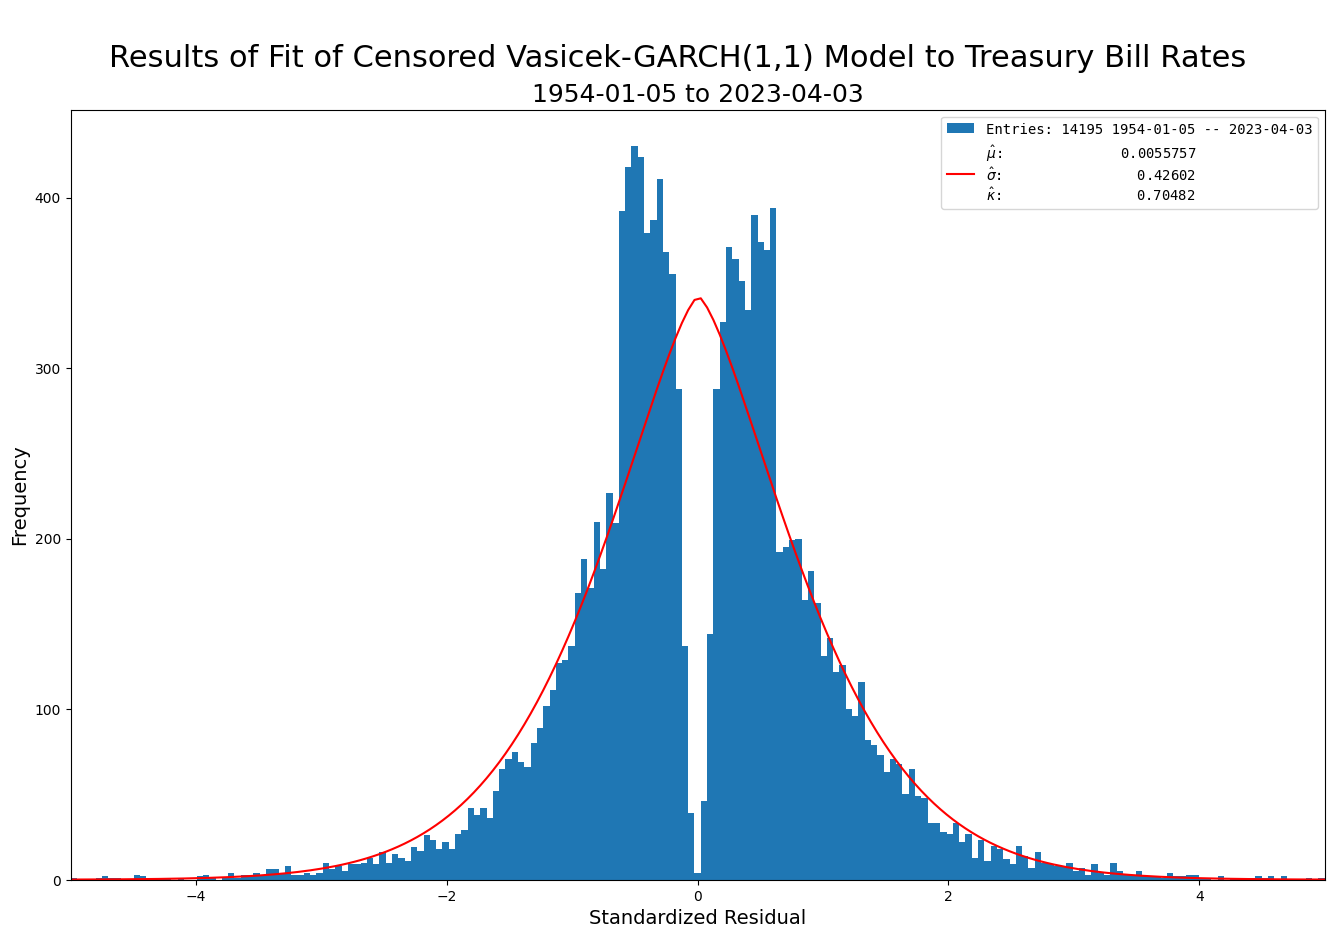

In [5]:
from arch.univariate import ARX, GARCH, GeneralizedError
from scipy.stats import gennorm # gennorm is parameterized in such a manner that kappa=1/beta and sigma=scale/(2^kappa)
censored=DTB3[DTB3["Change"]!=zero].copy()
display(censored)
model = ARX(censored["Change"]*hundred,censored['Rate'].shift().ffill()*hundred,lags=1) # in bp because arch whines about scaling --- bizarre but true
model.volatility = GARCH(1,0,1)
model.distribution = GeneralizedError()
fit=model.fit(update_freq=0)
print(fit.summary())
censored["Volatility"]=fit.conditional_volatility/hundred
censored["Innovations"]=censored["Change"]/censored["Volatility"]

# Figure 2.18
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nResults of Fit of Censored Vasicek-GARCH(1,1) Model to Treasury Bill Rates",fontsize=22)
plot.set_title("%s to %s" % (min(DTB3.index),max(DTB3.index)),fontsize=18)
xmin,xmax=-five,five
estimates=gennorm.fit(censored['Innovations'].dropna())
model=gennorm(*estimates)
samples,bins,patches=plot.hist(censored['Innovations'],bins=np.linspace(xmin,xmax,200),label="""Entries: %d %s -- %s""" % (
    censored["Change"].count(),censored.index[0],censored.index[-1],
))
plot.plot(bins,model.pdf(bins)*sum(samples)*(bins[-1]-bins[0])/len(bins),'-r',label="""$\\hat{\\mu}$:           %12.5g
$\\hat{\\sigma}$:           %12.5f
$\\hat{\\kappa}$:           %12.5f""" % (estimates[-2],estimates[-1]/np.power(two,estimates[0]),one/estimates[0]))
plot.set_xlabel("Standardized Residual",fontsize=14)
plot.set_ylabel("Frequency",fontsize=14)
plot.set_xlim(xmin,xmax)
plot.legend(fontsize=18,prop={'family':'monospace'});

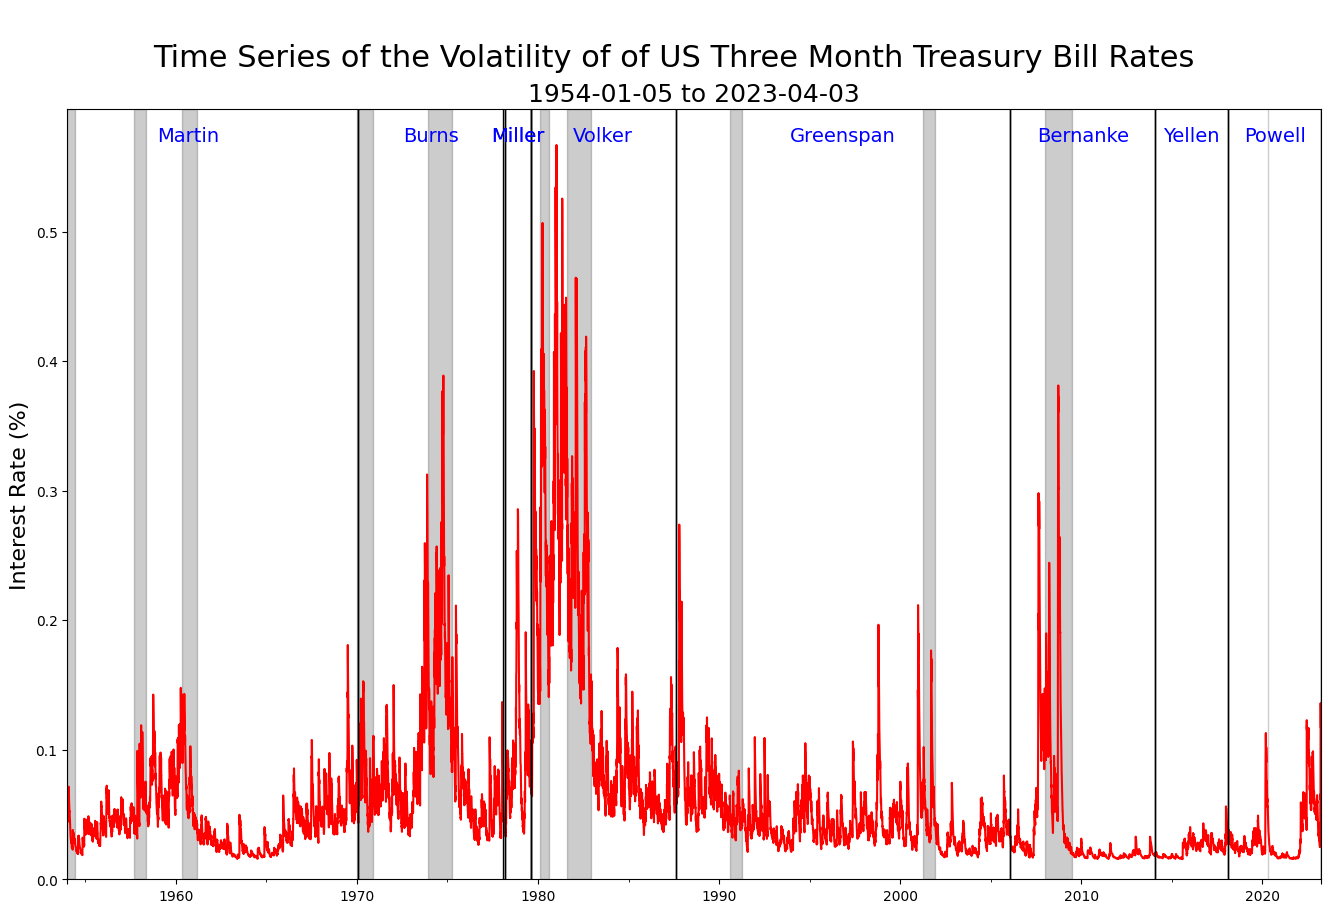

In [9]:
# Figure 2.19
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nTime Series of the Volatility of of US Three Month Treasury Bill Rates",fontsize=22)
plot.set_title("%s to %s" % (min(DTB3.index),max(DTB3.index)),fontsize=18)
censored['Volatility'].plot(ax=plot,color='red')

recbe=list(censored.index[censored['Recession']!=censored['Recession'].shift()])

for b,e in [(k.asfreq(*'MS'),v.asfreq(*'ME')) for k,v in zip(recbe[:-2:2],recbe[1::2])]:
    plot.axvspan(b.to_timestamp(),e.to_timestamp(),color='black',alpha=0.2)

plot.axvspan(recbe[-1].asfreq(*'MS').to_timestamp(),recbe[-1].asfreq(*'ME').to_timestamp(),color='black',alpha=0.2) # above construct doesn't get the COVID recession

for c,b,e in ('Martin','1951-04-02','1970-01-31'),('Burns','1970-02-01','1978-01-31'),('Miller','1978-03-08','1979-08-06'),\
             ('Miller','1978-03-08','1979-08-06'),('Volker','1979-08-06','1987-08-11'),('Greenspan','1987-08-11','2006-01-31'),\
             ('Bernanke','2006-02-01','2014-01-31'),('Yellen','2014-02-03','2018-02-3'),('Powell','2018-02-05',datetime.now()):        
    plot.axvline(b,color='black',lw=1)
    plot.axvline(e,color='black',lw=1)
    m=pd.Timestamp(b)+pd.Timedelta(days=(pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    if m<DTB3.index[0].to_timestamp():
        b=DTB3.index[0].to_timestamp()
        m=pd.Timestamp(b)+pd.Timedelta((pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    elif m>DTB3.index[-1].to_timestamp():
        b=DTB3.index[-1].to_timestamp()
        m=pd.Timestamp(b)+pd.Timedelta((pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    plot.text(m,0.57,c,fontsize=14,horizontalalignment='center',color='blue')
    
plot.set_xlabel(None)
plot.set_ylabel('Interest Rate (%)',fontsize=16)
plot.set_ylim(zero,None);

  0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/arch/univariate/distribution.py:1192: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
/usr/local/lib/python3.9/dist-packages/arch/univariate/distribution.py:1192: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


,mu,theta,phi,C,A,B,kappa
year,,,,,,,
1954,2.542492,-0.027955,0.265022,0.910487,1.897165e-01,0.706701,0.766810
1955,1.139329,-0.004157,0.332659,1.082616,5.302238e-02,0.859750,1.170258
1956,0.912934,-0.002285,0.127125,4.616623,9.295369e-02,0.693237,1.393058
1957,7.036114,-0.022102,0.236062,1.325752,3.653984e-11,0.936825,0.621229
1958,0.732159,-0.006205,0.291491,3.176783,1.131825e-01,0.829501,0.810968
...,...,...,...,...,...,...,...
2018,1.514820,-0.004836,-0.152291,0.041452,1.686084e-14,0.989322,1.006682
2019,-0.734451,0.001868,-0.073949,0.214008,8.804540e-02,0.880054,0.890762
2020,-0.070730,0.002147,-0.335488,0.416051,5.963385e-01,0.403662,1.002502


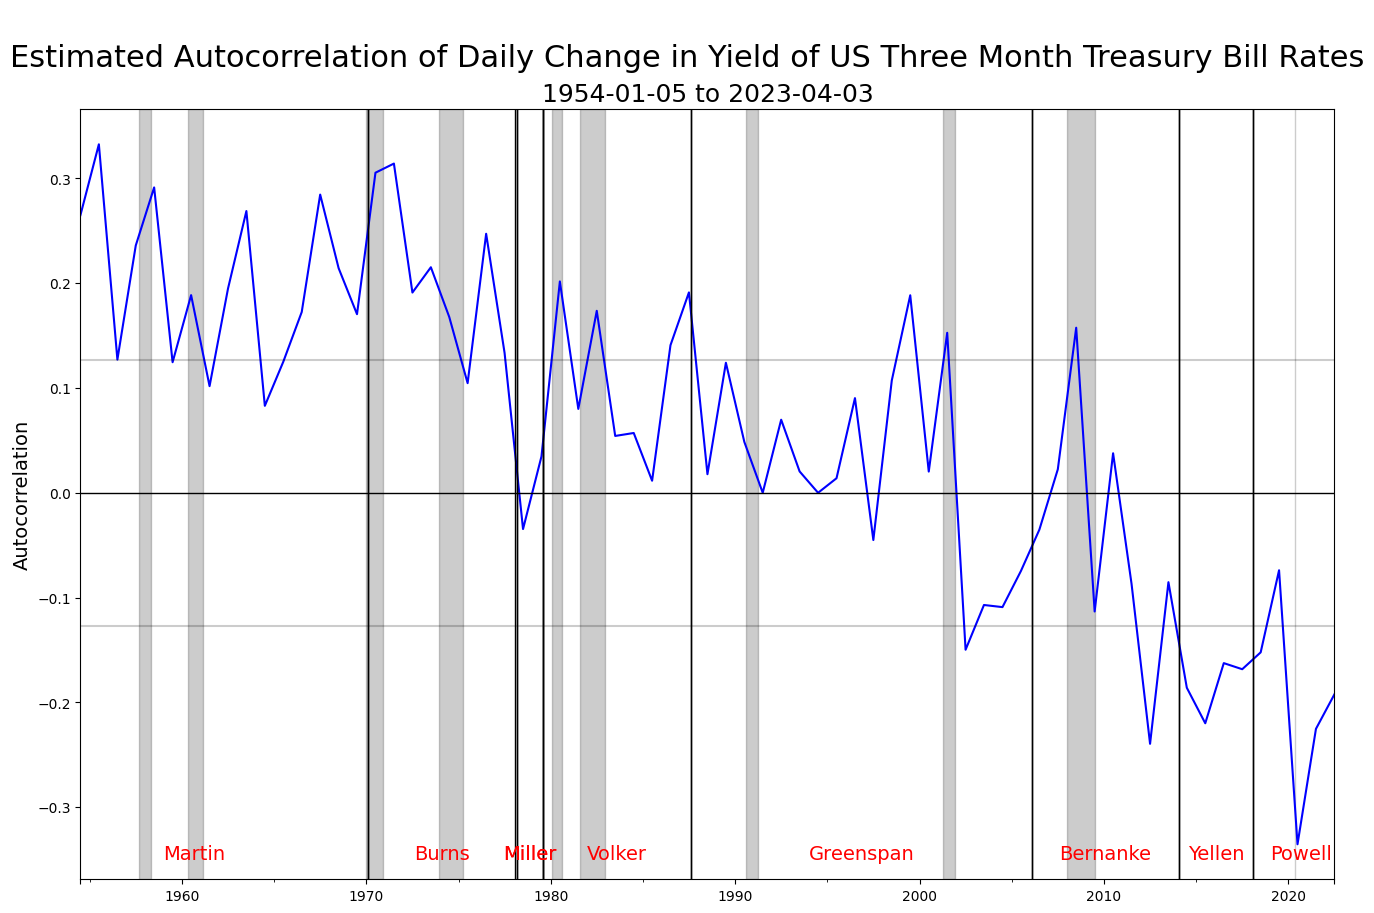

In [58]:
# fit model year-by-year
from tqdm.notebook import tqdm
results=pd.DataFrame({"year":[],"mu":[],"theta":[],"phi":[],"C":[],"A":[],"B":[],"kappa":[]}).set_index("year")
results.index=pd.DatetimeIndex(results.index).to_period('Y')

for year in tqdm(range(censored.index[0].year,censored.index[-1].year)):
    model = ARX(censored.loc[censored.index.year==year,"Change"]*hundred,censored.loc[censored.index.year==year,"Rate"].shift().ffill()*hundred,lags=[1])
    model.volatility = GARCH(1, 0, 1)
    model.distribution = GeneralizedError()
    fit=model.fit(update_freq=0,disp='off')

    if not fit.convergence_flag:
        mu,phi,theta,C,A,B,nu=tuple(fit.params)
        results.loc[year,"mu"]=mu
        results.loc[year,"theta"]=theta
        results.loc[year,"phi"]=phi
        results.loc[year,"C"]=C
        results.loc[year,"A"]=A
        results.loc[year,"B"]=B
        results.loc[year,"kappa"]=nu/two

display(results)

# Figure 2.20
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nEstimated Autocorrelation of Daily Change in Yield of US Three Month Treasury Bill Rates",fontsize=22)
plot.set_title("%s to %s" % (min(DTB3.index),max(DTB3.index)),fontsize=18)
results.index=pd.DatetimeIndex(map(lambda x:datetime(x,6,30),results.index)).to_period('B')
results['phi'].plot(ax=plot,color='blue')

recbe=list(censored.index[censored['Recession']!=censored['Recession'].shift()])

for b,e in [(k.asfreq(*'MS'),v.asfreq(*'ME')) for k,v in zip(recbe[:-2:2],recbe[1::2])]:
    plot.axvspan(b.to_timestamp(),e.to_timestamp(),color='black',alpha=0.2)

plot.axvspan(recbe[-1].asfreq(*'MS').to_timestamp(),recbe[-1].asfreq(*'ME').to_timestamp(),color='black',alpha=0.2) # above construct doesn't get the COVID recession

for c,b,e in ('Martin','1951-04-02','1970-01-31'),('Burns','1970-02-01','1978-01-31'),('Miller','1978-03-08','1979-08-06'),\
             ('Miller','1978-03-08','1979-08-06'),('Volker','1979-08-06','1987-08-11'),('Greenspan','1987-08-11','2006-01-31'),\
             ('Bernanke','2006-02-01','2014-01-31'),('Yellen','2014-02-03','2018-02-3'),('Powell','2018-02-05',datetime.now()):        
    plot.axvline(b,color='black',lw=1)
    plot.axvline(e,color='black',lw=1)
    m=pd.Timestamp(b)+pd.Timedelta(days=(pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    if m<DTB3.index[0].to_timestamp():
        b=DTB3.index[0].to_timestamp()
        m=pd.Timestamp(b)+pd.Timedelta((pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    elif m>DTB3.index[-1].to_timestamp():
        b=DTB3.index[-1].to_timestamp()
        m=pd.Timestamp(b)+pd.Timedelta((pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    plot.text(m,-0.35,c,fontsize=14,horizontalalignment='center',color='red')
  
for y in -two/np.sqrt(249e0),two/np.sqrt(249e0):
    plot.axhline(y,color='black',alpha=0.2)

plot.axhline(color='black',linewidth=1)
plot.set_xlabel(None)
plot.set_ylabel('Autocorrelation',fontsize=14);